In [2]:
from pygalfitm.VOs import splus

import splusdata

conn = splusdata.connect("gustavo", "asdflkjh")

You have access to internal data


In [3]:
_ = splus.get_splus("test", 52.43008289777575, -33.557141932864596, 200, 'data/', 'outputs/', conn)

File data/test_i.fits.fz already exists. If you mean to replace it then use the argument "overwrite=True".
File data/test_r.fits.fz already exists. If you mean to replace it then use the argument "overwrite=True".
File data/test_g.fits.fz already exists. If you mean to replace it then use the argument "overwrite=True".
finished
finished
finished


In [16]:
from astropy.io import fits

In [54]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [18]:
f = fits.open("outputs/testss.fits")

In [24]:
print(f)

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x171cdd970>, <astropy.io.fits.hdu.image.ImageHDU object at 0x171cdde80>, <astropy.io.fits.hdu.image.ImageHDU object at 0x171d2b1c0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x171d60040>, <astropy.io.fits.hdu.image.ImageHDU object at 0x171d60400>, <astropy.io.fits.hdu.image.ImageHDU object at 0x171d606a0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x171d60940>, <astropy.io.fits.hdu.image.ImageHDU object at 0x171d60be0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x171d60e80>, <astropy.io.fits.hdu.image.ImageHDU object at 0x171d95100>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x171d95340>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x171d956a0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x171d958e0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x171d60d30>]


In [37]:
from astropy.table import Table

Table.read(f[10])

VERSION,INITFILE,CONSTRNT,FITSECT,CONVBOX,KERNEL,MINSIGMA,NITER,FIRSTCON,LASTCON,NDOF,NFREE,NFIX,NDATA,NMASK,REFWLBAND,LOWDWLBAND,HIGHDWLBAND,CPUTIME_SETUP,CPUTIME_FIT,CPUTIME_TOTAL,CHISQ,CHI2NU,LOGFILE,FLAGS
str33,str514,str514,str514,str514,str514,float32,int32,int32,int32,int32,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,str514,str81
galfitm-1.4.4,outputs/galfit.feedme,none,"[1:200,1:200]","200, 200",,0.0,27,2,2,119989,11,10,120000,0,7670.59,-2912.1,0.0,0.004302,4.935377,5.033668,165255.22,1.3772532,outputs/testss.galfit.02,A-6 A-3 A-4 A-5


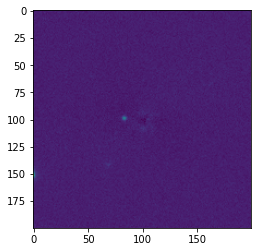

In [34]:
plt.imshow(f[9].data)

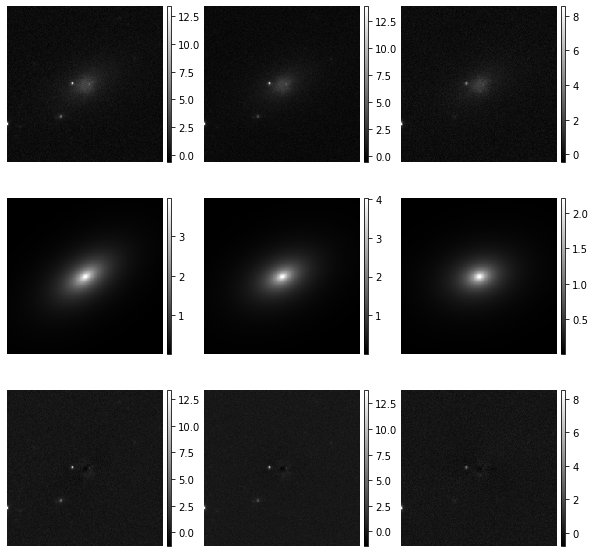

In [58]:
fig = plt.figure(figsize=(10, 10))



for i in range(1, 10):
    ax = fig.add_subplot(3,3, i)
    im = ax.imshow(f[i].data, cmap='gray', interpolation='None')
    ax.axis('off')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')



In [63]:
out = open("outputs/testss.galfit.01.band", "r").read()

In [67]:
for i in out.split("\n"):
    print(i)


#  Input menu file: outputs/galfit.feedme

#  Chi^2/nu = 1.377,  Chi^2 = 165255.224,  Ndof = 119989

# IMAGE and GALFIT CONTROL PARAMETERS
A) data/test_i.fits,data/test_r.fits,data/test_g.fits      # Input data image (FITS file)
A1) i,r,g              # Band labels
A2) 7670.59,6251.83,4758.49     # Band wavelengths
B) outputs/testss.fits      # Output data image block
C) none,none,none 0.000   # Sigma image and min. sigma factor (made from data if blank or "none") 
D) data/psf_test_i.fits,data/psf_test_r.fits,data/psf_test_g.fits          # Input PSF image and (optional) diffusion kernel
E) 1                   # PSF fine sampling factor relative to data 
F) none,none,none      # Bad pixel mask (FITS image or ASCII coord list)
G) none                # File with parameter constraints (ASCII file) 
H) 1    200  1    200  # Image region to fit (xmin xmax ymin ymax)
I) 200    200          # Size of the convolution box (x y)
J) 23.344,23.535,23.490      # Magnitude photometric zeropoint 
K)